## Library

In [1]:
# Core PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp.autocast_mode import autocast
from torch.amp.grad_scaler import GradScaler

# Torchvision imports
from torchvision import datasets, models, transforms
from torchvision.models import resnet18, ResNet18_Weights

# Utility imports
from torchsummary import summary
from tqdm import tqdm
from copy import deepcopy

# Data handling & system
import os
import zipfile
import pathlib
import pandas as pd
import numpy as np
from PIL import Image

# Visualization
import matplotlib.pyplot as plt

# Misc
import random
import time

In [2]:
# Boost performance for CUDA
torch.backends.cudnn.benchmark = True

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dir

In [4]:
zip_path = os.path.join("C:/IIUM/AI Note IIUM/Deep_Learning/Midterm/data", "Kaggle2Data.zip")
extract_path = "C:/IIUM/AI Note IIUM/Deep_Learning/Midterm/data/Kaggle2"

# Only extract if not already extracted
if not os.path.exists(extract_path) or not os.listdir(extract_path):
    print("Extracting ZIP file with style...")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        files = zip_ref.infolist()

        for file in tqdm(files, desc="Extracting", unit="file", ncols=80, bar_format="{l_bar}{bar} | {n_fmt}/{total_fmt}"):
            zip_ref.extract(file, extract_path)

    print("✨ Extraction complete.")
else:
    print("✅ Already extracted. Skipping extraction.")


✅ Already extracted. Skipping extraction.


In [5]:
train_dir = "C:/IIUM/AI Note IIUM/Deep_Learning/Midterm/data/Kaggle Mix/Train"
test_dir = "C:/IIUM/AI Note IIUM/Deep_Learning/Midterm/data/Kaggle Mix/Test"


# Get the class names from the target directory
classes = sorted([entry.name for entry in list(os.scandir(train_dir))])
print(f"Class names: {classes}")

Class names: ['glasses', 'plain']


In [6]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'glasses': 0, 'plain': 1}

In [7]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(train_dir)

There are 2 directories and 0 images in 'C:/IIUM/AI Note IIUM/Deep_Learning/Midterm/data/Kaggle Mix/Train'.
There are 0 directories and 3521 images in 'C:/IIUM/AI Note IIUM/Deep_Learning/Midterm/data/Kaggle Mix/Train\glasses'.
There are 0 directories and 3495 images in 'C:/IIUM/AI Note IIUM/Deep_Learning/Midterm/data/Kaggle Mix/Train\plain'.


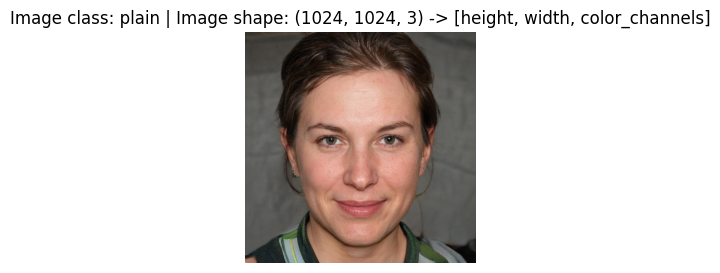

In [8]:
# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(pathlib.Path(train_dir).glob("*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## Custom DataSet & Data Loader (No Augmentation)


In [9]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None, extensions={".jpg", ".jpeg", ".png"}):
        self.image_paths = [
            path for ext in extensions 
            for path in pathlib.Path(image_dir).rglob(f"*{ext}")
        ]
        self.transform = transform

        # Get all class names from folder names
        class_names = sorted({path.parent.name for path in self.image_paths})
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        print(f"📸 Found {len(self.image_paths)} images across {len(self.class_to_idx)} classes.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # ensure consistent 3-channel RGB

        # Get label from folder name
        label_name = image_path.parent.name
        label = self.class_to_idx[label_name]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [10]:
# Define transformations
data_transform = transforms.Compose(
    [transforms.Resize((256,256)), 
     transforms.ToTensor(),
])

In [11]:
train_data_custom = CustomDataset(image_dir=train_dir, transform=data_transform) # type: ignore
test_data_custom = CustomDataset(image_dir=test_dir, transform=data_transform) # type: ignore

📸 Found 7016 images across 2 classes.
📸 Found 1680 images across 2 classes.


In [12]:
len(train_dir), len(test_dir)

(64, 63)

In [13]:
# Create ImageFolder datasets for comparison if not already created
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data) == len(train_data)) & (len(test_data) == len(test_data)))

True


In [14]:
#######################################################
#                  Create Dataloader                  #
#######################################################

# Turn train and test custom Dataset's into DataLoader's

num_workers = (os.cpu_count() or 2) // 2

train_loader = DataLoader(
    dataset=train_data,
    batch_size=128,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=128,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

## Convolutional Neural Network

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)


In [15]:
class GlassesNetRGB(nn.Module):
    def __init__(self):
        super(GlassesNetRGB, self).__init__()
        
        # C1: Conv layer (5x5 kernel), from 3 input channels (RGB) to 6 feature maps
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  # 256 -> 252

        # S2: Subsampling: Avg pooling (2x2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # 252 -> 126

        # C3: Conv layer (5x5), from 6 to 16 feature maps
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)  # 126 -> 122

        # S4: Subsampling: Avg pooling (2x2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # 122 -> 61

        # Feature maps now: 16 x 61 x 61
        self.fc1 = nn.Linear(16 * 61 * 61, 120)  # F5
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 84)           # F6
        self.dropout2 = nn.Dropout(p=0.5)
        self.output = nn.Linear(84, 2)          # Binary output

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.output(x)
        return x


In [16]:
# Load model 
model = GlassesNetRGB()

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

GlassesNetRGB(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=84, out_features=2, bias=True)
)

In [17]:
model.to(device)
summary(model, (3, 256, 256)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 252, 252]             456
         AvgPool2d-2          [-1, 6, 126, 126]               0
            Conv2d-3         [-1, 16, 122, 122]           2,416
         AvgPool2d-4           [-1, 16, 61, 61]               0
            Linear-5                  [-1, 120]       7,144,440
           Dropout-6                  [-1, 120]               0
            Linear-7                   [-1, 84]          10,164
           Dropout-8                   [-1, 84]               0
            Linear-9                    [-1, 2]             170
Total params: 7,157,646
Trainable params: 7,157,646
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 5.91
Params size (MB): 27.30
Estimated Total Size (MB): 33.96
-------------------------------------

## Training Loop

In [18]:

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    scaler = GradScaler()  # AMP scaler magic
    start_time = time.time()
    model = model.to(device)
    best_acc = 0.0
    best_model_state = deepcopy(model.state_dict())
    history = []

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")

        # TRAIN with AMP scaler
        train_loss, train_acc = run_epoch(model, train_dataloader, loss_criterion, optimizer, device, train=True, scaler=scaler)

        # VALIDATION without optimizer and no grad scaling needed
        val_loss, val_acc = run_epoch(model, test_dataloader, loss_criterion, device=device, train=False, scaler=None)

        history.append([train_loss, val_loss, train_acc, val_acc])

        print(f"Epoch {epoch+1:03d} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}% | "
              f"Time: {time.time() - epoch_start:.2f}s")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = deepcopy(model.state_dict())
            torch.save(model, 'best_model_Glasses.pt')

    model.load_state_dict(best_model_state)
    total_time = time.time() - start_time
    print(f"\nTraining complete in {total_time:.2f}s. Best Validation Accuracy: {best_acc*100:.2f}%")
    return model, history


def run_epoch(model, dataloader, loss_criterion, optimizer=None, device='cuda', train=True, scaler=None):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        if train and optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            # AMP autocast context — float16 precision for forward pass
            with autocast(device_type='cuda', enabled=(scaler is not None)): 
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)

            if train and optimizer is not None:
                if scaler is not None:
                    # scale loss, backward, optimizer step, update scaler
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        correct += (preds == labels).sum().item()
        total += inputs.size(0)

    avg_loss = total_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc


In [19]:
# Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, loss_fn, optimizer, train_loader, test_loader, num_epochs)


Epoch 1/10
Epoch 001 | Train Loss: 0.6069, Acc: 66.42% | Val Loss: 0.3183, Acc: 84.52% | Time: 115.92s

Epoch 2/10
Epoch 002 | Train Loss: 0.2268, Acc: 91.33% | Val Loss: 0.1135, Acc: 96.61% | Time: 25.57s

Epoch 3/10
Epoch 003 | Train Loss: 0.1236, Acc: 95.70% | Val Loss: 0.0761, Acc: 97.26% | Time: 26.93s

Epoch 4/10
Epoch 004 | Train Loss: 0.0928, Acc: 97.19% | Val Loss: 0.0580, Acc: 97.86% | Time: 27.54s

Epoch 5/10
Epoch 005 | Train Loss: 0.0687, Acc: 97.68% | Val Loss: 0.0409, Acc: 98.51% | Time: 27.28s

Epoch 6/10
Epoch 006 | Train Loss: 0.0551, Acc: 98.29% | Val Loss: 0.0389, Acc: 98.69% | Time: 24.52s

Epoch 7/10
Epoch 007 | Train Loss: 0.0389, Acc: 98.79% | Val Loss: 0.0440, Acc: 98.27% | Time: 25.17s

Epoch 8/10
Epoch 008 | Train Loss: 0.0275, Acc: 98.96% | Val Loss: 0.0379, Acc: 98.57% | Time: 29.93s

Epoch 9/10
Epoch 009 | Train Loss: 0.0250, Acc: 99.16% | Val Loss: 0.0411, Acc: 98.45% | Time: 28.85s

Epoch 10/10
Epoch 010 | Train Loss: 0.0203, Acc: 99.27% | Val Loss: 0.0

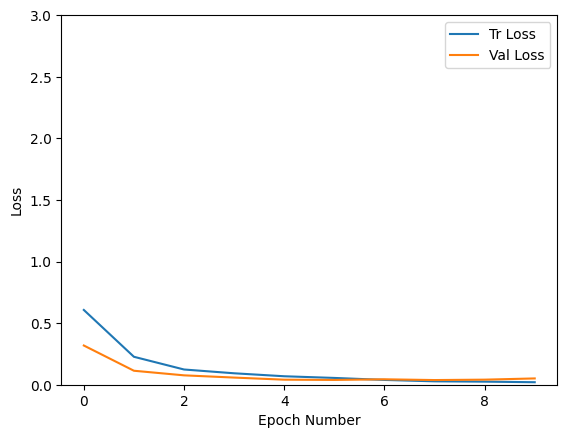

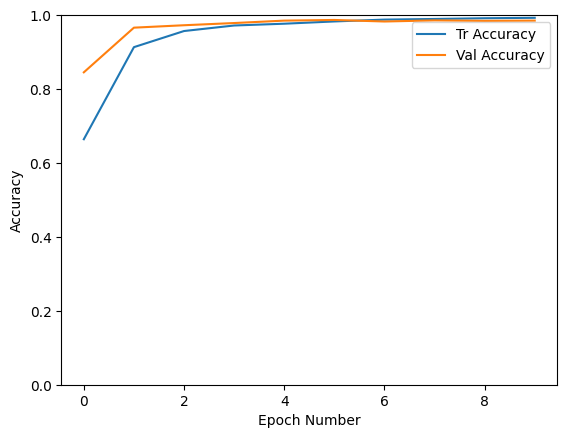

In [20]:
# Loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# Accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

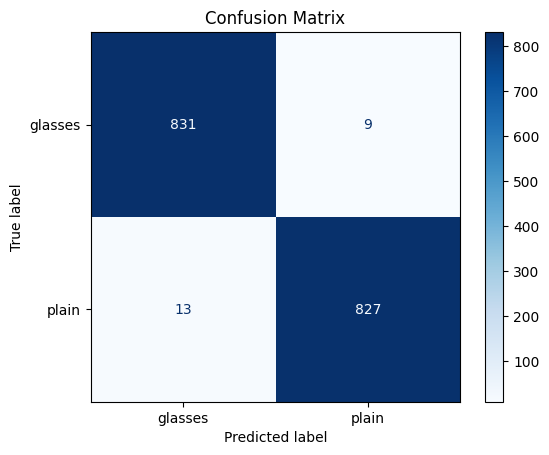

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions and true labels from the test set
all_preds = []
all_labels = []

trained_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = trained_model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues) # type: ignore
plt.title("Confusion Matrix")
plt.show()

## Using Pre Trained Model


In [27]:
# Load model with updated syntax
weights = ResNet18_Weights.DEFAULT
model_Pre = resnet18(weights=weights)

for param in model_Pre.parameters():
    param.requires_grad = False

# Unfreeze only the final layer
for param in model_Pre.fc.parameters():
    param.requires_grad = True

# Adjust the final layer for 2 output classes
num_ftrs = model_Pre.fc.in_features
model_Pre.fc = nn.Linear(num_ftrs, 2)

# Loss and optimizer
loss_fn_Pre = nn.CrossEntropyLoss()
optimizer_Pre = torch.optim.SGD(model_Pre.parameters(), lr=0.001, momentum=0.9)

# Move model to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_Pre.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
device

device(type='cuda', index=0)

In [28]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [29]:
model_Pre.to(device)
summary(model_Pre, (3, 224, 224)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [30]:
def train_and_validate(model_Pre, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    scaler = GradScaler()  # AMP scaler
    start_time = time.time()
    model_Pre = model_Pre.to(device)
    best_acc = 0.0
    best_model_state = deepcopy(model_Pre.state_dict())
    history = []

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")

        # TRAIN with AMP
        train_loss, train_acc = run_epoch(model_Pre, train_dataloader, loss_criterion, optimizer, device, train=True, scaler=scaler)

        # VALIDATION
        val_loss, val_acc = run_epoch(model_Pre, test_dataloader, loss_criterion, device=device, train=False, scaler=None)

        history.append([train_loss, val_loss, train_acc, val_acc])

        print(f"Epoch {epoch+1:03d} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}% | "
              f"Time: {time.time() - epoch_start:.2f}s")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = deepcopy(model_Pre.state_dict())
            torch.save(model_Pre, 'best_model_Glasses_ResNet18.pt')

    model_Pre.load_state_dict(best_model_state)
    total_time = time.time() - start_time
    print(f"\nTraining complete in {total_time:.2f}s. Best Validation Accuracy: {best_acc*100:.2f}%")
    return model_Pre, history


def run_epoch(model_Pre, dataloader, loss_criterion, optimizer=None, device='cuda', train=True, scaler=None):
    if train:
        model_Pre.train()
    else:
        model_Pre.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        if train and optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            with autocast(device_type='cuda', enabled=(scaler is not None)):
                outputs = model_Pre(inputs)
                loss = loss_criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)

            if train and optimizer is not None:
                if scaler is not None:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        correct += (preds == labels).sum().item()
        total += inputs.size(0)

    avg_loss = total_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc


In [33]:
# Train the model for 10 epochs

num_epochs = 10
trained_model_Pre, history_Pre = train_and_validate(model_Pre, loss_fn_Pre, optimizer_Pre, train_loader, test_loader, num_epochs)


Epoch 1/10
Epoch 001 | Train Loss: 0.4548, Acc: 79.20% | Val Loss: 0.3131, Acc: 89.94% | Time: 28.28s

Epoch 2/10
Epoch 002 | Train Loss: 0.2493, Acc: 93.97% | Val Loss: 0.2253, Acc: 94.52% | Time: 26.68s

Epoch 3/10
Epoch 003 | Train Loss: 0.1974, Acc: 95.51% | Val Loss: 0.1830, Acc: 96.25% | Time: 27.37s

Epoch 4/10
Epoch 004 | Train Loss: 0.1699, Acc: 96.14% | Val Loss: 0.1614, Acc: 96.37% | Time: 25.63s

Epoch 5/10
Epoch 005 | Train Loss: 0.1497, Acc: 96.78% | Val Loss: 0.1429, Acc: 96.90% | Time: 36.56s

Epoch 6/10
Epoch 006 | Train Loss: 0.1403, Acc: 96.61% | Val Loss: 0.1320, Acc: 97.38% | Time: 29.08s

Epoch 7/10
Epoch 007 | Train Loss: 0.1285, Acc: 96.96% | Val Loss: 0.1366, Acc: 97.08% | Time: 29.74s

Epoch 8/10
Epoch 008 | Train Loss: 0.1196, Acc: 97.28% | Val Loss: 0.1185, Acc: 97.62% | Time: 25.70s

Epoch 9/10
Epoch 009 | Train Loss: 0.1174, Acc: 97.29% | Val Loss: 0.1111, Acc: 97.62% | Time: 26.44s

Epoch 10/10
Epoch 010 | Train Loss: 0.1090, Acc: 97.31% | Val Loss: 0.10

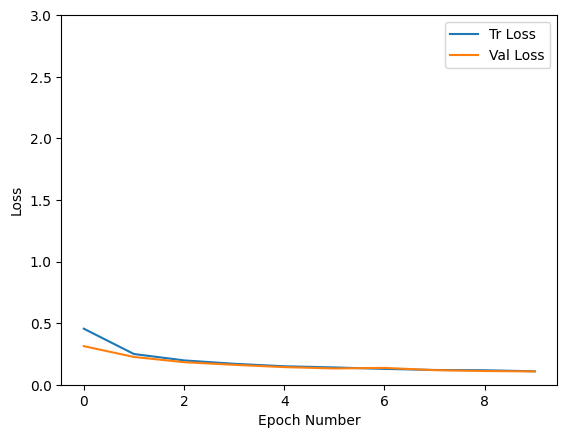

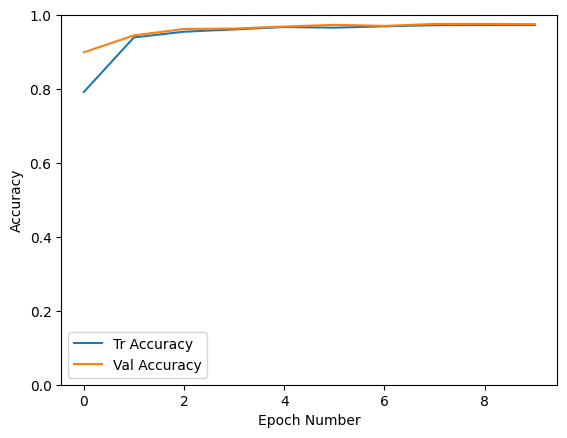

In [34]:
# Loss curve

history = np.array(history_Pre)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# Accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

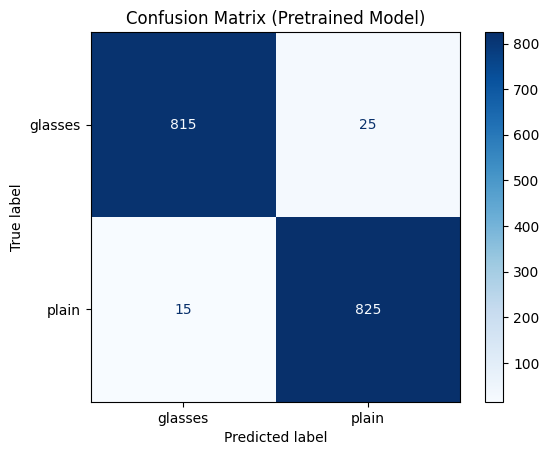

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions and true labels from the test set
all_preds = []
all_labels = []

trained_model_Pre.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = trained_model_Pre(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues) # type: ignore
plt.title("Confusion Matrix (Pretrained Model)")
plt.show()